In [1]:
 !nvidia-smi

Wed Dec 14 18:20:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   29C    P8     9W / 250W |    104MiB / 12188MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro P6000        Off  | 00000000:81:00.0 Off |                  Off |
| 26%   

In [2]:
# from utils.cloudant_utils import cloudant_db as db
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch import nn
from collections import defaultdict
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from prepare_sequence import prepareSequenceForBERT
import random
from tqdm.auto import tqdm

/users/kent/jmaharja/anaconda3/envs/crawler/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.empty_cache()
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [4]:
BATCH_SIZE = 16
MAX_LEN = 512
EPOCHS = 16
RANDOM_SEED = 42
model_name = 'bert-base-uncased'

# 1. Read the input data 

In [5]:
# repos = [r for r in db.get_query_result({"type": "release"}, ["_id", "releases"], limit=10000, raw_result=True)["docs"]]
# values = [r for release in repos for r in release["releases"]]
# df = pd.DataFrame(values)
# df['contributors'] = df['contributors'].apply(lambda x:
#                                               [i for i in x if i is not None] if isinstance(x, list)
#                                               else [])
# df = df[~df['readme'].isnull()]
# new_df = df.groupby("repo").agg({"readme": list,
#                                  "total_stars": list,
# #                                  "forks": sum,
# #                                  "downloads": sum,
# #                                  "contributors": sum
# #                                  "releases": count
#                                 })
# new_df = new_df[new_df['readme'].map(len) > 1]
# # new_df = new_df[:10]
# new_df['k'] = new_df['total_stars'].map(lambda x: random.randint(2, len(x)))
# new_df['readme1'] = new_df.apply(lambda x: x.readme[:x.k], axis=1)
# new_df['target_val'] = new_df.apply(lambda x: x.total_stars[x.k-1], axis=1)
# new_df['sequence']= new_df['readme1'].apply(prepareSequenceForBERT)
# new_df['target'] = new_df.apply(lambda x: 1 if x.target_val> 600 else 0, axis=1)

In [6]:
new_df = pd.read_csv('csv/inputForBERT_2022_09_21-09_14PM.csv') 
new_df['target'].value_counts()

0    2687
1     509
Name: target, dtype: int64

In [7]:
class ReadmeDataSet(Dataset):
   def __init__(self, _df, tokenizer, max_len):
      self._df = _df
      self.tokenizer = tokenizer
      self.max_len = max_len

   def __len__(self):
      return len(self._df)

   def __getitem__(self, item):
      _sequence = self._df.iloc[item]['sequence']
      target = self._df.iloc[item]['target']
      encoding = self.tokenizer.encode_plus(_sequence,
                                     None,
                                     max_length = self.max_len,
                                     truncation=True,
                                     add_special_tokens=True,
                                     padding='max_length',
                                     return_token_type_ids=True)

      return {
      'sequence': _sequence,
      'input_ids': torch.tensor(encoding.input_ids, dtype=torch.long),
      'attention_mask':  torch.tensor(encoding.attention_mask, dtype=torch.long),
      'token_type_ids': torch.tensor(encoding.token_type_ids, dtype=torch.long),
      'targets': torch.tensor(target, dtype=torch.long)
      }

In [8]:
def create_data_loader(_df, tokenizer, max_len, batch_size):
   ds = ReadmeDataSet(_df = _df, tokenizer=tokenizer, max_len=max_len)
   return DataLoader(ds, batch_size=batch_size, num_workers=0)

 ## 1.1 Create the Model 

In [9]:
class BertForRepoClassification(nn.Module):
    def __init__(self, n_classes):
        super(BertForRepoClassification, self).__init__()
        self.model = BertModel.from_pretrained('bert-base-uncased')
        self.drop_out = nn.Dropout(0.5)
#         self.pre_classifier = torch.nn.Linear(768, 768)
        self.classifier = nn.Linear(768, n_classes)
        
    def forward(self, input_ids, attention_mask,token_type_ids):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask,token_type_ids=token_type_ids)
#         last_hidden_state = last_hidden_state[:, 0]
#         print(outputs)
#         print(pooled_output.shape)
        pooled_output = self.drop_out(outputs.pooler_output)
        output = self.classifier(pooled_output)
        return output

Import BERT Tokenizer and BERT Model

In [10]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
#                                                       num_labels=2,
#                                                       output_attentions= False,
#                                                       output_hidden_states= False)
bert_model = BertForRepoClassification(2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

df_train, df_test = train_test_split(new_df, test_size=0.4, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((1917, 8), (639, 8), (640, 8))

In [12]:
train_data_loader = create_data_loader(df_train, bert_tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, bert_tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, bert_tokenizer, MAX_LEN, BATCH_SIZE)
new_df.shape, df_train.shape, df_val.shape, df_test.shape

((3196, 8), (1917, 8), (639, 8), (640, 8))

In [13]:
# TEST the tokenizer and data loader
# sequence = prepareSequenceForBERT(new_df.iloc[1]['readme'][:7])
# label = new_df.iloc[1]['total_stars'][6]
# tokens = bert_tokenizer.encode_plus(
#             sequence,
#             None,
#             max_length= 512,
#             truncation=True,
#             add_special_tokens=True,
# #             pad_to_max_length=True,
#             padding = True,
#             return_token_type_ids=True
#         )
# # print(f' Sentence: {sequence}')
# # print(f' Tokens: {tokens}')
# # print(f' Tokens.token_type_ids: {tokens.token_type_ids}')
# # print(f' Tokens.input_ids: {len(tokens.input_ids)}')
# output = {
#       'input_ids': torch.tensor(tokens.input_ids, dtype=torch.long),
#       'attention_mask':  torch.tensor(tokens.attention_mask, dtype=torch.long),
#       'token_type_ids': torch.tensor(tokens.token_type_ids, dtype=torch.long),
#       'targets': torch.tensor(label, dtype=torch.long)
#     }
# print(output['input_ids'].shape)
# model = BertModel.from_pretrained('bert-base-uncased')
# outputs = model(input_ids=output['input_ids'],attention_mask=output['attention_mask'])
# print(outputs)

In [14]:
# model = BertModel.from_pretrained('bert-base-uncased')
# model = model.to(device)
# for d in train_data_loader:
#     input_ids = d["input_ids"].to(device)
#     attention_mask = d["attention_mask"].to(device)
#     token_type_ids = d["token_type_ids"].to(device)
#     targets = d["targets"].to(device)
#     outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
#     print(outputs.last_hidden_state.shape)
#     print(input_ids.shape)
#     print(outputs.keys())
#     print(d['sequence'])
#     break

# 2. Train the model

In [15]:
optimizer = AdamW(bert_model.parameters(), lr=2e-5, correct_bias=False, no_deprecation_warning=True)
bert_model = bert_model.to(device)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [16]:
def train_epoch( model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
#     _, preds = torch.max(outputs.logits, dim=1)
#     loss = loss_fn(outputs.logits, targets)
    
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)   

#     all_linear1_params = torch.cat([x.view(-1) for x in model.parameters()])
#     all_linear2_params = torch.cat([x.view(-1) for x in model.parameters()])
#     l1_regularization = 0.3 * torch.norm(all_linear1_params, 1)
#     l2_regularization = 0.01 * torch.norm(all_linear2_params, 2)

#     loss = loss + l1_regularization + l2_regularization

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [17]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
#       _, preds = torch.max(outputs.logits, dim=1)
      _, preds = torch.max(outputs, dim=1)

#       loss = loss_fn(outputs.logits, targets)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [63]:
a = torch.tensor([1, 0, 1])
b = torch.tensor([0, 1, 0])
r = torch.sum(a == b)
r

tensor(0)

In [49]:
def get_predictions(model, data_loader):
  model = model.eval()

  sequences = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["sequence"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

#       _, preds = torch.max(outputs.logits, dim=1)
#       probs = F.softmax(outputs.logits, dim=1)
      _, preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)
#       print(preds, probs, targets)
      sequences.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return outputs, sequences, predictions, prediction_probs, real_values

In [19]:
print(40*"*", 'Training')
current_time = datetime.now().strftime("%Y_%m_%d-%I_%M%p")
print(current_time)
history = defaultdict(list)
loss_fn = nn.CrossEntropyLoss().to(device)
best_accuracy = 0
# progress_bar = tqdm(range(total_steps))

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(bert_model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(bert_model, val_data_loader, loss_fn, device, len(df_val) )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      curr_time = datetime.now().strftime("%Y_%m_%d-%I_%M%p")
      torch.save(bert_model.state_dict(), 'checkpoint/best_model_state' + current_time+'.bin')
      best_accuracy = val_acc
#     progress_bar.update(1)

**************************************** Training
2022_12_14-06_21PM
Epoch 1/16
----------
Train loss 0.43902272215733923 accuracy 0.8382889932185706
Val   loss 0.43813699912279847 accuracy 0.8419405320813772

Epoch 2/16
----------
Train loss 0.42887643513580165 accuracy 0.838810641627543
Val   loss 0.44933018889278176 accuracy 0.8419405320813772

Epoch 3/16
----------
Train loss 0.420401006223013 accuracy 0.8435054773082942
Val   loss 0.4326240077614784 accuracy 0.8435054773082943

Epoch 4/16
----------
Train loss 0.4411556982745727 accuracy 0.837245696400626
Val   loss 0.42731108516454697 accuracy 0.8419405320813772

Epoch 5/16
----------
Train loss 0.40666810690114896 accuracy 0.8450704225352113
Val   loss 0.4530502397567034 accuracy 0.8403755868544601

Epoch 6/16
----------
Train loss 0.4027745706339677 accuracy 0.8466353677621283
Val   loss 0.43286914490163325 accuracy 0.8419405320813772

Epoch 7/16
----------
Train loss 0.3683343805372715 accuracy 0.8518518518518519
Val   loss 0.

In [20]:
# plt.plot(history['train_acc'], label='train accuracy')
# plt.plot(history['val_acc'], label='validation accuracy')

# plt.title('Training history')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()
# plt.ylim([0, 1]);
# plt.savefig('images/training_history '+current_time+'.png')

In [ ]:
# outputs_v, y_sequences_v, y_pred_v, y_pred_probs_v, y_test_v = get_predictions(bert_model, val_data_loader)
# generate_auc(y_test_v.numpy(), y_pred_probs_v[:, 1].numpy(), current_time)
# display_prediction_df(y_sequences_v, y_test_v, y_pred_v, y_pred_probs_v, current_time, False)

# 3. Model Evaluation

In [59]:
def display_prediction_df(y_sequences, y_test, y_pred, y_pred_probs, fileName=None ):
    y_pred_probs_pd = [y.numpy() for y in y_pred_probs]
    someListOfLists = list(zip(y_sequences, y_test.numpy(), y_pred.numpy(), y_pred_probs[:, 1:].numpy().squeeze(), y_pred_probs_pd ))
    npa = np.asarray(someListOfLists)
    dff = pd.DataFrame(someListOfLists, columns = ['readme', 'Real', 'Predicted', 'Pred-prob', 'All Pred-probs' ])
    print(dff)
    if fileName:
        dff.to_csv('csv/pred_result_'+ fileName+'.csv')

In [106]:
from sklearn import metrics

def generate_auc(label, pred, c_pred=None, both=False, fileName=None):
    plt.figure(figsize=(8,6))
    plt.plot([0, 1], [0, 1],'r--')

#     pred = y_pred_probs[:, 1].numpy()
#     label = y_test.numpy()
    fpr, tpr, thresh = metrics.roc_curve(label, pred)
    auc = metrics.roc_auc_score(label, pred)
    plt.plot(fpr, tpr, label=f'BERT, auc = {str(round(auc,3))}')

    if both:
        pred = c_pred
        fpr, tpr, thresh = metrics.roc_curve(label, c_pred)
        auc = metrics.roc_auc_score(label, c_pred)
        plt.plot(fpr, tpr, label=f'Calibrated BERT, auc = {str(round(auc,3))}')

    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.title("AUC-ROC for two models")
    plt.legend()
    plt.show()
    if fileName:
        plt.savefig('images/Log_ROC_'+ fileName +'.png')


In [23]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np
 
class IdentityEstimator(BaseEstimator, ClassifierMixin):
    '''
    An identity estimator used for calibrating probability data
    '''
 
    def __init__(self):
        self.classes_= [0, 1]
        # pass
       
 
    def __getstate__(self):
        # Copy the object's state from self.__dict__ which contains
        # all our instance attributes. Always use the dict.copy()
        # method to avoid modifying the original state.
        state = self.__dict__.copy()
 
        return state
 
    def __setstate__(self, state):
        # Restore instance attributes
        self.__dict__.update(state)
        
 
    def fit(self, X, y, sample_weight=None):
        return self
 
    def predict_proba(self, X):
        
        assert X.shape[1] == 1
        probs = np.concatenate((1 - X, X), axis=1)
        return probs

In [24]:
from sklearn.calibration import calibration_curve
def plot_calibration_curve(name, fig_index, probs, y_test):
    """Plot calibration curve for est w/o and with calibration. """

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    frac_of_pos, mean_pred_value = calibration_curve(y_test, probs, n_bins=10 , normalize=True)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}')
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plot ({name})')
    
    ax2.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")

In [25]:
outputss, y_sequences, y_pred, y_pred_probs, y_test = get_predictions(bert_model, train_data_loader)

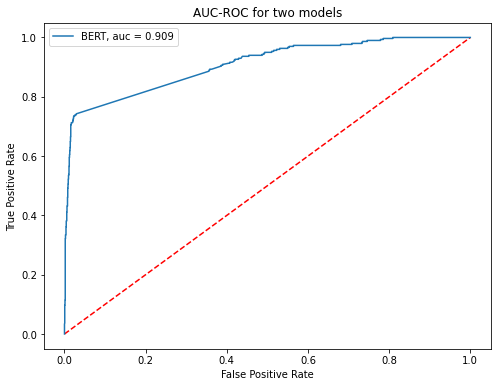

In [108]:
generate_auc(y_test.numpy(), y_pred_probs[:, 1].numpy() )

In [44]:
test_acc, _ = eval_model(bert_model, test_data_loader, loss_fn, device, len(df_test))
test_acc.item()

0.8140625

In [29]:
# bert_model = BertForRepoClassification(2)
# bert_model.load_state_dict(torch.load('checkpoint/best_model_state2022_11_30-11_28AM.bin'))

# Result without Calibrated Classifier Prediction 

In [99]:
outputss_t, y_sequences_t, y_pred_t, y_pred_probs_t, y_test_t = get_predictions(bert_model, test_data_loader)

In [ ]:
# display_prediction_df(y_sequences, y_test_t, y_pred_t, y_pred_probs_t, 'test_'+ current_time )

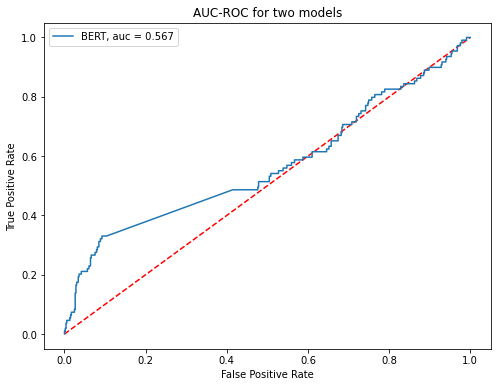

In [109]:
generate_auc(y_test_t.numpy(), y_pred_probs_t[:, 1].numpy())

In [ ]:
plot_calibration_curve("BERT", 1, y_pred_probs_t[:, 1].numpy(), y_test_t.numpy())

# Result after Calibrated Classifier Prediction

In [30]:
id_est = IdentityEstimator()
# probs = id_est.predict_proba(y_pred_probs[:, 1:])
# print(probs)

In [31]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_clf = CalibratedClassifierCV(base_estimator=id_est, cv="prefit", method="isotonic")
calibrated_clf.fit(y_pred_probs[:, 1:], y_test)

CalibratedClassifierCV(base_estimator=IdentityEstimator(), cv='prefit',
                       method='isotonic')

In [101]:
prob_c = calibrated_clf.predict_proba(y_pred_probs_t[:, 1:])

/users/kent/jmaharja/anaconda3/envs/crawler/lib/python3.9/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


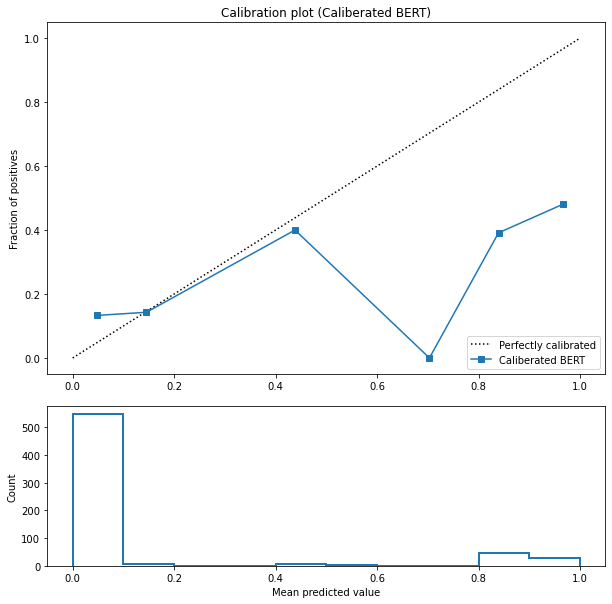

In [102]:
plot_calibration_curve("Caliberated BERT", 1, prob_c[:, 1], y_test_t.numpy())

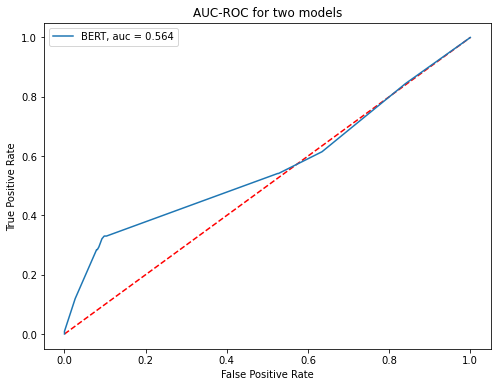

In [103]:
generate_auc(y_test_t.numpy(),  prob_c[:, 1], False)